In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model

from PIL import Image
from nltk.translate import bleu_score

# Import Custom Module
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)


Using TensorFlow backend.


In [2]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

***

In [3]:
from src.utils.config import IMAGES_DIR
from src.utils.sets import (
    init_image_descriptions_map,
    load_set_images,
    init_image_descriptions_map_set,
    data_generator
)

from src.utils.image import load_image, load_image_embedding_map
from src.utils.sequence import clean, init_idx_word_map, init_word_idx_map

from src.nn import NeuralImageCaptioning, NICInference

***

## Understanding and formating the data

In [4]:
image2descriptions = init_image_descriptions_map()

image2descriptions['101654506_8eb26cfb60']

['A brown and white dog is running through the snow .',
 'A dog is running in the snow',
 'A dog running through snow .',
 'a white and brown dog is running through a snow covered field .',
 'The white and brown dog is running over the surface of the snow .']

***

## Data Cleaning

In [5]:
clean(
    'A HellO! How12 are yoU>??'
)

'a hello are you'

In [6]:
for img_name, descriptions in image2descriptions.items():
    image2descriptions[img_name] = [clean(descr) for descr in descriptions]

In [7]:
image2descriptions['101654506_8eb26cfb60']

['a brown and white dog is running through the snow',
 'a dog is running in the snow',
 'a dog running through snow',
 'a white and brown dog is running through a snow covered field',
 'the white and brown dog is running over the surface of the snow']

***

## Create a Vocabulary

In [8]:
vocabulary = set()

for key in image2descriptions.keys():
    [vocabulary.update(descr.split()) for descr in image2descriptions[key]]

In [9]:
vocabulary.update('0')
vocabulary.update(['<START>'])
vocabulary.update(['<END>'])

In [10]:
print('Vocabulary size: {}'.format(len(vocabulary)))

Vocabulary size: 8767


### Sort the Vocabulary lexically

In [11]:
vocabulary = sorted(vocabulary)

## Word2Idx and Idx2Word maps

In [12]:
word2idx = init_word_idx_map(vocabulary)
idx2word = init_idx_word_map(vocabulary)

In [13]:
word2idx['dog']

2224

In [14]:
idx2word[2224]

'dog'

***

## Max Description Length

In [15]:
descriptions = []

for key, val in image2descriptions.items():
    for descr in val:
        descriptions.append(descr)

print('Total number of descriptions: {}'.format(len(descriptions)))

Total number of descriptions: 40460


In [16]:
longets_description = max(descriptions, key=lambda x: len(x.split()))

print('Longes description:\n\n"{}"'.format(longets_description))

Longes description:

"an africanamerican man wearing a green sweatshirt and blue vest is holding up dollar bills in front of his face while standing on a busy sidewalk in front of a group of men playing instruments"


In [17]:
max_description_length = len(longets_description.split()) + 2

print('Max Description Length: {}'.format(max_description_length))

Max Description Length: 37


***

## Train/Dev/Test split

In [18]:
train_images = load_set_images('train')
dev_images = load_set_images('dev')
test_images = load_set_images('test')

print('Train size: {}'.format(len(train_images)))
print('Dev size: {}'.format(len(dev_images)))
print('Test size: {}'.format(len(test_images)))

Train size: 6000
Dev size: 1000
Test size: 1000


### Init Image->Descriptions Maps Sets

In [19]:
train_image2descriptions = init_image_descriptions_map_set(train_images, image2descriptions)
dev_image2descriptions = init_image_descriptions_map_set(dev_images, image2descriptions)
test_image2descriptions = init_image_descriptions_map_set(test_images, image2descriptions)

print('Train size: {}'.format(len(train_image2descriptions)))
print('Dev size: {}'.format(len(dev_image2descriptions)))
print('Test size: {}'.format(len(test_image2descriptions)))

Train size: 6000
Dev size: 1000
Test size: 1000


In [20]:
train_image2descriptions['2513260012_03d33305cf']

['a black dog is running after a white dog in the snow',
 'black dog chasing brown dog through snow',
 'two dogs chase each other across the snowy ground',
 'two dogs play together in the snow',
 'two dogs running through a low lying body of water']

***

## Merge Train and Dev, hold-out set: Test

In [21]:
train_image2descriptions = {**train_image2descriptions, **dev_image2descriptions}

In [22]:
print('Train size: {}'.format(len(train_image2descriptions)))
print('Test size: {}'.format(len(test_image2descriptions)))

Train size: 7000
Test size: 1000


***

## Creating Image-Embedding Maps

In [23]:
train_image2embedding = load_image_embedding_map('train', train_image2descriptions)

Creating "train" Image-Embedding Map...
Instructions for updating:
Colocations handled automatically by placer.
Done.


***

In [24]:
EMBEDDING_DIM = 300
NUM_HIDDEN_NEURONS = [256, 256]

***

# Model

![NIC_model](../../img/NIC.png)

In [25]:
neural_image_captioning = NeuralImageCaptioning(
    EMBEDDING_DIM, max_description_length, len(vocabulary), NUM_HIDDEN_NEURONS, word2idx)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [26]:
print(neural_image_captioning.model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_embedding_input (InputLay (None, 2048)         0                                            
__________________________________________________________________________________________________
sequence_input (InputLayer)     (None, 37)           0                                            
__________________________________________________________________________________________________
top_image_encoder (Model)       (None, 1, 300)       2405676     image_embedding_input[0][0]      
__________________________________________________________________________________________________
sequence_decoder (Model)        (None, 37, 8767)     5978899     sequence_input[0][0]             
                                                                 top_image_encoder[1][0]          
Total para

***

## Run

### Callbacks

In [27]:
filepath = '../weights/nic-weights.hdf5'
checkpoint = ModelCheckpoint(filepath, verbose=True)

callbacks = [checkpoint]

In [62]:
neural_image_captioning.model.load_weights('../weights/nic-weights.hdf5')

neural_image_captioning.model.compile(Adam(0.00005), loss='categorical_crossentropy')

In [ ]:
num_epochs = 1000
batch_size = 128
steps = (len(train_image2descriptions) * 5) // batch_size

train_data_generator = data_generator(
    train_image2descriptions,
    train_image2embedding,
    word2idx,
    batch_size,
    max_description_length,
    len(vocabulary),
)

neural_image_captioning.model.fit_generator(
    generator=train_data_generator,
    steps_per_epoch=steps,
    epochs=num_epochs,
    verbose=True,
    callbacks=callbacks,
)

Epoch 1/1000


***

## Test

In [52]:
inference = NICInference(neural_image_captioning, word2idx)

In [53]:
def show_img(path_to_img):
    img = Image.open(path_to_img)
    img.load()
    plt.imshow(np.asarray(img, dtype='int32'));

def evaluate(img_id, beam_width=3):
    print('Image ID: {}'.format(img_id))
    print('='*50)
    print()
    img = load_image(img_id)
    
    greedy_hypothesis = inference.greedy_search(img)
    beam_hypothesis = inference.beam_search(img, beam_width=beam_width)
    references = image2descriptions[img_id]

    print('Greedy Search: {}'.format(greedy_hypothesis))
    print('Beam Search: {}'.format(beam_hypothesis))
    print()
    
    print('BLEU score Greedy Search: {}'.format(bleu_score.sentence_bleu(references, greedy_hypothesis)))
    print('BLEU score Beam Search: {}'.format(bleu_score.sentence_bleu(references, beam_hypothesis)))
    print()
    
    print('Greedy Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, greedy_hypothesis)))
    print('Beam Search Hypothesis Log Probabilty: {}'.format(inference.predict_logprob(img, beam_hypothesis)))
    
    show_img(IMAGES_DIR+img_id+'.jpg')

Image ID: 2884420269_225d27f242

Greedy Search: a girl in a pink dress dances with a boy in a pink shirt
Beam Search: a girl in the red are playing

BLEU score Greedy Search: 0.3440448334818191
BLEU score Beam Search: 0.4905352959432553

Greedy Search Hypothesis Log Probabilty: -123.19393920898438
Beam Search Hypothesis Log Probabilty: -63.07635498046875


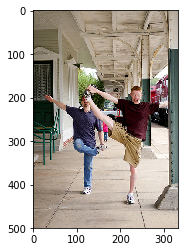

In [54]:

evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=10
)

Image ID: 1765164972_92dac06fa9

Greedy Search: a girl in a purple shirt looks puzzled
Beam Search: a girl in a red and white looks at the camera

BLEU score Greedy Search: 0.6251009616184915
BLEU score Beam Search: 0.6925315485289942

Greedy Search Hypothesis Log Probabilty: -68.89128112792969
Beam Search Hypothesis Log Probabilty: -103.23519134521484


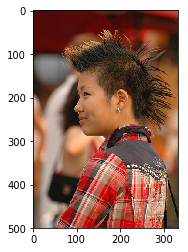

In [55]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=10
)

Image ID: 2346401538_f5e8da66fc

Greedy Search: two young girls are standing in front of a large tree
Beam Search: three three young people in the sun

BLEU score Greedy Search: 0.4970607544044715
BLEU score Beam Search: 0.4489965421966536

Greedy Search Hypothesis Log Probabilty: -93.8503646850586
Beam Search Hypothesis Log Probabilty: -53.10249328613281


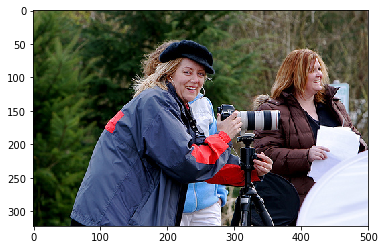

In [56]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=50
)

Image ID: 3106026005_473a7b1c8c

Greedy Search: a man in a black hat is smoking a cigarette
Beam Search: a man drinking man is smoking

BLEU score Greedy Search: 0.5387267434862872
BLEU score Beam Search: 0.33768946412943057

Greedy Search Hypothesis Log Probabilty: -86.10142517089844
Beam Search Hypothesis Log Probabilty: -53.580360412597656


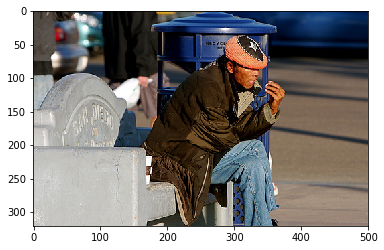

In [57]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=50
)

Image ID: 1417031097_ab656bc4bd

Greedy Search: a man is standing in front of a large metal structure
Beam Search: a man is walking

BLEU score Greedy Search: 0.3862403949109194
BLEU score Beam Search: 0.2179167448138725

Greedy Search Hypothesis Log Probabilty: -96.72938537597656
Beam Search Hypothesis Log Probabilty: -31.349390029907227


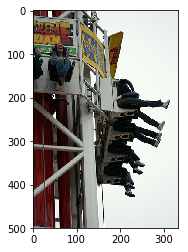

In [58]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=100
)

Image ID: 2541104331_a2d65cfa54

Greedy Search: a brown dog is running through the water
Beam Search: a black dog is running through water suit

BLEU score Greedy Search: 0.9666651315708603
BLEU score Beam Search: 0.781922082312999

Greedy Search Hypothesis Log Probabilty: -72.4179458618164
Beam Search Hypothesis Log Probabilty: -84.05330657958984


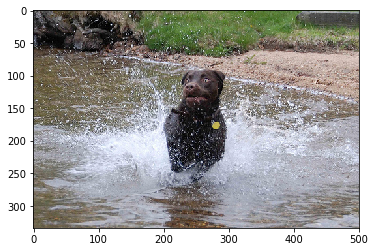

In [59]:
evaluate(
    np.random.choice(list(test_image2descriptions.keys())), beam_width=100
)